In [2]:
pip install scikit-learn pandas matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D,Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.python.keras.utils.vis_utils import plot_model


In [6]:
BASE_DIR="ML_NutriCheck"
train_dir="ML_NutriCheck/train"
test_dir="ML_NutriCheck/test"
validation_dir="ML_NutriCheck/validation"

print(f'Contents of base directory: {os.listdir(BASE_DIR)}')
print(f'Contents of train directory: {os.listdir(train_dir)}')
print(f'Contents of validation directory: {os.listdir(validation_dir)}')

Contents of base directory: ['test', 'train', 'validation']
Contents of train directory: ['gado-gado', 'omelette', 'bibimbap', 'cheesecake', 'chicken noodle', 'chicken porridge', 'chicken Soto', 'chicken wings', 'chocolate_cake', 'churros', 'cup_cakes', 'donuts', 'fish_and_chips', 'french_fries', 'french_toast', 'fried shrimp', 'fried_rice', 'green bean porridge', 'grilled chicken', 'gyoza', 'hamburger', 'hot_dog', 'ice_cream', 'ikan bakar', 'kupat tahu', 'lasagna', 'macaroni_and_cheese', 'macarons', 'meatball', 'nasi kuning', 'nasi uduk', 'oxtail soup', 'oysters', 'pad_thai', 'pancakes', 'pizza', 'ramen', 'red_velvet_cake', 'rendang', 'risotto', 'samosa', 'sashimi', 'satay', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'sushi', 'tacos', 'takoyaki', 'Tempeh', 'tiramisu', 'waffles']
Contents of validation directory: ['gado-gado', 'omelette', 'bibimbap', 'cheesecake', 'chicken noodle', 'chicken porridge', 'chicken Soto', 'chicken wings', 'chocolate_cake', 'churr

<Figure size 640x480 with 0 Axes>

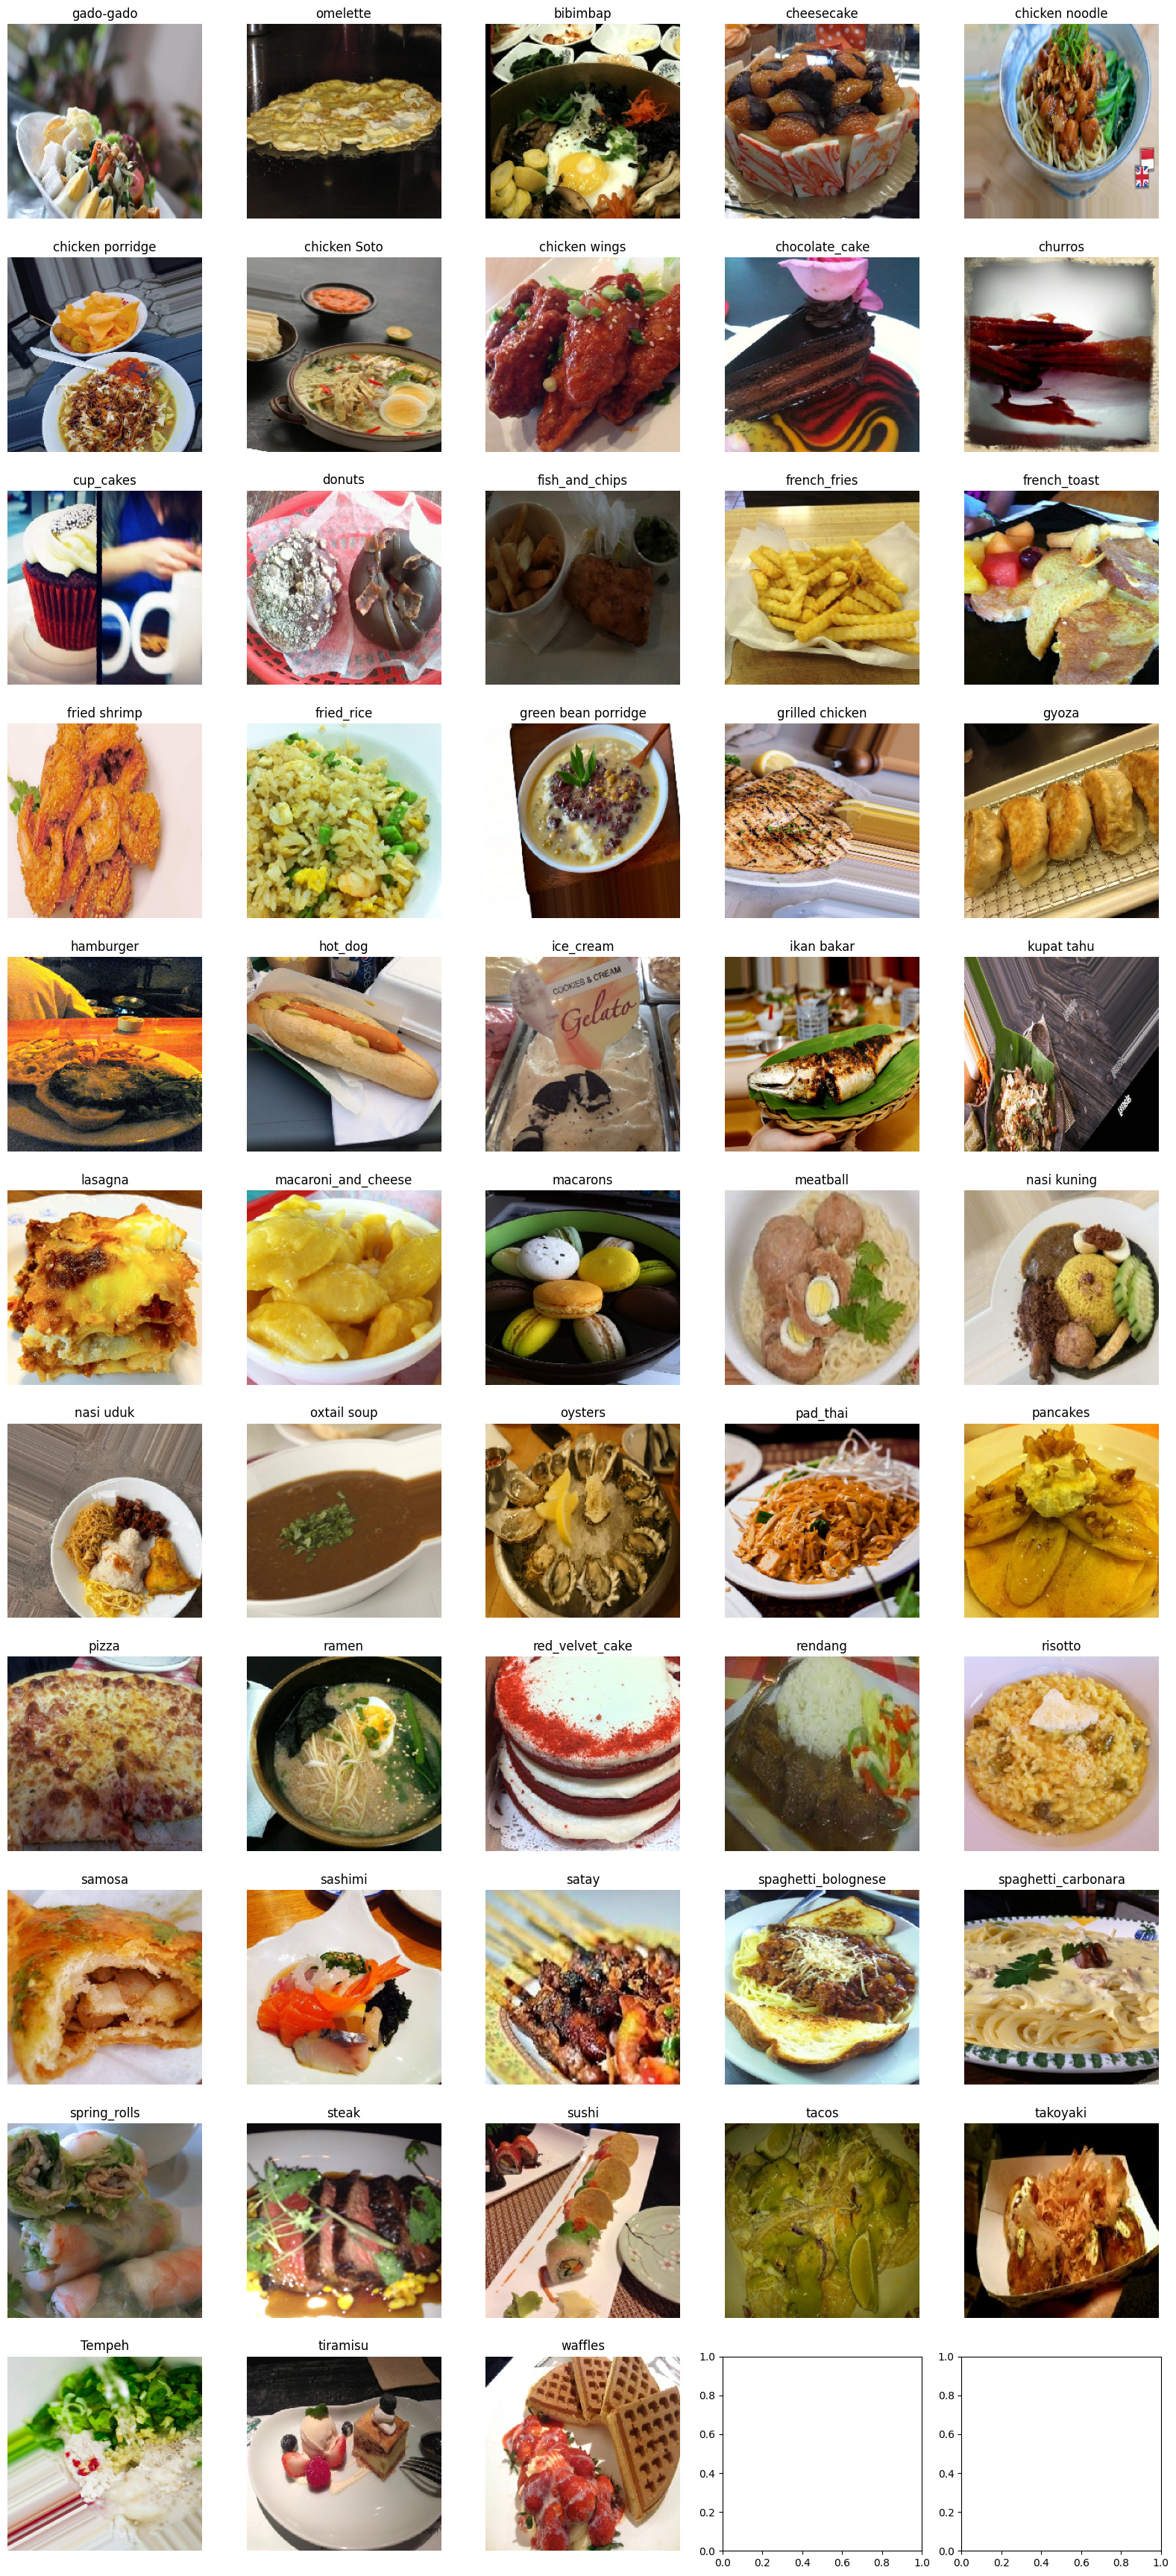

<Figure size 640x480 with 0 Axes>

In [7]:
import random
nrows=11
ncols=5

BASE_DIR="ML_NutriCheck"
train_dir="ML_NutriCheck/train"
test_dir="ML_NutriCheck/test"
validation_dir="ML_NutriCheck/validation"

fig=plt.gcf()
fig,axes=plt.subplots(nrows,ncols,figsize=(ncols*4, nrows*4))

class_names=os.listdir(train_dir)[:nrows * ncols]

for i, class_name in  enumerate (class_names):
  class_dir=os.path.join(train_dir,class_name)
  image_files=os.listdir(class_dir)
  image_path=os.path.join(class_dir,random.choice(image_files))
  img_to_array=load_img(image_path,target_size=(224,224))
  ax = axes[i // ncols, i % ncols]
  ax.imshow(img_to_array)
  ax.axis('off')
  ax.set_title(class_name)

plt.show()
plt.tight_layout()

In [8]:
train_dir="ML_NutriCheck/train"
test_dir="ML_NutriCheck/test"
validation_dir="ML_NutriCheck/validation"

def create_data_generators(train_dir,validation_dir):


  train_datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
  )       
  validation_datagen=ImageDataGenerator(rescale=1.0/255.)  

  train_generator=train_datagen.flow_from_directory(
      train_dir,
      target_size=(224,224),
      batch_size=32,
      class_mode='categorical',
      shuffle=True
  )  

  validation_generator=validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(224,224),
      batch_size=32,
      class_mode='categorical',
      shuffle=True
  )         

  return train_generator,validation_generator                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [9]:
train_generator,validation_generator=create_data_generators(train_dir,validation_dir)

Found 42400 images belonging to 53 classes.
Found 5300 images belonging to 53 classes.


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV2

pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3),pooling='avg')

for layer in pre_trained_model.layers:
    layer.trainable = False

inputs = pre_trained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pre_trained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(53, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

I0000 00:00:1732385604.567358  149379 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2179 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,445,301 (9.33 MB)

 Trainable params: 187,317 (731.71 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
checkpoint_model = ModelCheckpoint('checkpoint_NutriCheck_Eficnet.keras',
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only=True,
                             verbose=1)

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7
)


In [15]:
from keras.callbacks import ModelCheckpoint
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= 0.85 and logs.get('val_accuracy') >= 0.83:
      print(' Accuracy training has been stopped.')
      self.model.stop_training=True

callback=myCallback()

In [45]:
history= model.fit(
    train_generator,
    epochs=20,   
    verbose=1,
    validation_data = validation_generator,
    callbacks = [reduce_lr, checkpoint_model,callback]
)

Epoch 1/20
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5897 - loss: 1.4931
Epoch 1: val_accuracy improved from 0.59623 to 0.65019, saving model to checkpoint_NutriCheck_Eficnet.keras
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 265s 200ms/step - accuracy: 0.5897 - loss: 1.4931 - val_accuracy: 0.6502 - val_loss: 1.2423 - learning_rate: 1.0000e-04
Epoch 2/20
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6289 - loss: 1.3188
Epoch 2: val_accuracy improved from 0.65019 to 0.67000, saving model to checkpoint_NutriCheck_Eficnet.keras
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 260s 196ms/step - accuracy: 0.6289 - loss: 1.3188 - val_accuracy: 0.6700 - val_loss: 1.1488 - learning_rate: 1.0000e-04
Epoch 3/20
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6520 - loss: 1.2378
Epoch 3: val_accuracy improved from 0.67000 to 0.68755, saving model to checkpoint_NutriCheck_Eficnet.keras
1325/1325 ━━━━━━━━━━━━━━━━━━━━ 258s 195ms/step - accuracy: 0.6520 - loss: 1.2378 - val_accuracy: 0.6875 

In [ ]:
for layer in pre_trained_model.layers[-20:]:  
    layer.trainable = True


model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history= model.fit(
    train_generator,
    epochs=100, 
    verbose=1,
    validation_data=validation_generator,
    callbacks=[reduce_lr, checkpoint_model, callback]
)

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Reset validation generator
validation_generator.reset()

# Generate predictions
Y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)  # Ambil prediksi dengan probabilitas tertinggi
y_true = validation_generator.classes  # True labels dari generator

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = validation_generator.class_indices  # Mapping kelas
class_names = {v: k for k, v in class_names.items()}  # Membalik dictionary
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Menambahkan ticks untuk nama kelas
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names.values(), rotation=45)
plt.yticks(tick_marks, class_names.values())

# Tambahkan angka di setiap cell
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names.values())

print("Classification Report:")
print(report)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming you have matplotlib installed
import matplotlib.pyplot as plt

# Path to your test folder (replace with your actual path)
test_folder = "ML_NutriCheck/test"

# Input image size based on your model (replace with your model's input size)
IMG_SIZE = (224, 224)

# Assuming you have loaded your validation generator (replace with your code)
class_names = validation_generator.class_indices  # Get class names from generator
class_names = {v: k for k, v in class_names.items()}  # Invert index to class name

# Function to preprocess image
def process_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize to 0-1
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict images from the test folder
for image_file in os.listdir(test_folder):
    image_path = os.path.join(test_folder, image_file)

    # Skip non-image files
    if not image_file.lower().endswith(('png', 'jpg', 'jpeg')):
        continue

    # Preprocess the image
    img = process_image(image_path)

    # Make prediction using your model (replace with your prediction code)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_names[predicted_class]

    # Print prediction result
    print(f"Image: {image_file} -> Predicted: {predicted_class_name}")

    # Optional: Visualize prediction (assuming you have loaded the image)
    plt.imshow(img)  # Assuming you have loaded the image using load_img
    plt.title(f"Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

In [ ]:
print(class_names)


In [ ]:
import os

# Define the path to the directory
dir_path = r'D:\wiwi/model'

# Check if the directory exists
if os.path.exists(dir_path):
    print(f"The directory '{dir_path}' exists.")
else:
    print(f"The directory '{dir_path}' does not exist.")


In [ ]:
dir_path = r'D:\wiwi/model'
tf.saved_model.save(model,dir_path)

In [ ]:
# Define your model (assuming model is already trained)
model_path = 'D:/wiwi/model'

# Save the model as TensorFlow SavedModel format
tf.saved_model.save(model, model_path)

# Convert the SavedModel to TFLite format
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = 'D:/wiwi/model/model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to {tflite_model_path}")

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(dir_save_model)
tflite_model = converter.convert()

# Menyimpan model TFLite ke file .tflite
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi menjadi format TFLite.")

In [10]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
import tensorflow as tf
print("Physical devices:", tf.config.list_physical_devices())

Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
